In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
%config Completer.use_jedi = False

## Downloading relevant data

In [2]:
MTUM = yf.download('MTUM', start='2010-04-30', end="2020-05-11")
MOM = yf.download('MOM', start='2010-04-30', end="2020-05-11")
DJTMNMO = pd.read_csv('djtmnmo.csv', parse_dates=['Effective date']).set_index('Effective date')
SPY = yf.download('SPY', start='2010-04-30', end="2020-05-11")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
DJTMNMO

,Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index,Dow Jones U.S. Thematic Market Neutral Momentum Index
Effective date,,
2010-04-30,957.32,NaN
2010-05-01,957.32,NaN
2010-05-02,957.32,NaN
2010-05-03,972.82,NaN
2010-05-04,959.97,NaN
...,...,...
2020-05-05,1363.20,1443.13
2020-05-06,1372.54,1452.91
2020-05-07,1373.43,1454.12


## Let's plot all of the data to see what it looks like

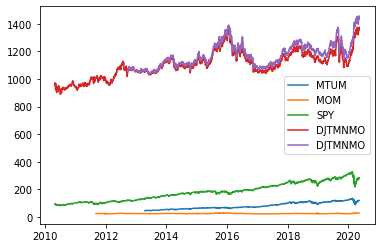

In [4]:
plt.plot(MTUM['Adj Close'], label='MTUM')
plt.plot(MOM['Adj Close'], label='MOM')
plt.plot(SPY['Adj Close'], label='SPY')
plt.plot(DJTMNMO['Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index'], label='DJTMNMO')
plt.plot(DJTMNMO['Dow Jones U.S. Thematic Market Neutral Momentum Index'], label='DJTMNMO')
plt.legend()

## Question 2

Let's plot DJTMNMO and MOM over overlapping time periods and see if we notice any patterns. We do an inner join on the two time series to match all dates with each other so we can plot the overlapping period peroperly.

In [5]:
merged = MOM[['Adj Close']].merge(DJTMNMO[['Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index']],
                         how='inner', 
                         left_index=True, 
                         right_index=True).rename(columns={'Adj Close':'MOM', 
                                                           'Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index':'DJT'}).dropna()
merged

,MOM,DJT
2011-09-07,25.100000,1010.24
2011-09-08,25.090000,1013.09
2011-09-09,24.840000,1006.50
2011-09-12,24.850000,1007.44
2011-09-13,25.059999,1013.16
...,...,...
2020-05-04,28.639999,1347.57
2020-05-05,29.392700,1363.20
2020-05-06,29.174999,1372.54
2020-05-07,29.318501,1373.43


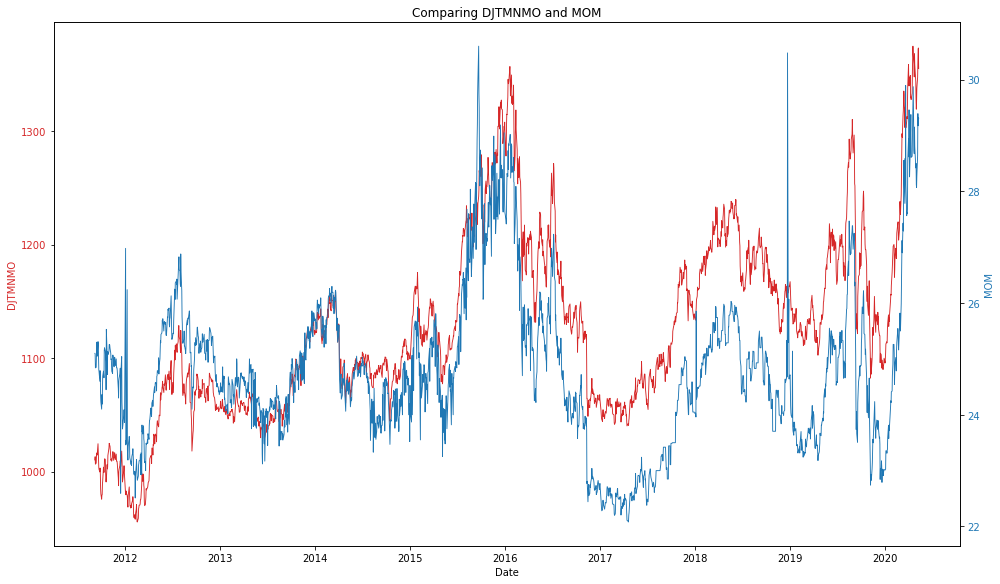

In [6]:
fig, ax1 = plt.subplots(figsize=(14,8))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('DJTMNMO', color=color)
ax1.plot(merged['DJT'], label='DJTMNMO', color=color, linewidth=0.9)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('MOM', color=color)
ax2.plot(merged['MOM'], color=color, linewidth=0.9)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Comparing DJTMNMO and MOM")
plt.show()

We can see that the time series definitely looks correlated and could potentially be cointegrated as well. Let's see if we can verify correlation or cointegration

In [7]:
from sklearn.linear_model import LinearRegression

Let's run a regression between the two series and see if we can note anything about the spread time series (aka the residual)

In [8]:
reg = LinearRegression().fit(merged[['MOM']], merged[['DJT']])
reg.coef_[0][0], reg.intercept_[0]

(41.74574139515065, 92.60287152689011)

Let's construct the spread / residual series now

In [9]:
spread = merged['DJT'] - reg.coef_[0][0]*merged['MOM'] - reg.intercept_[0]
spread

2011-09-07   -130.180996
2011-09-08   -126.913530
2011-09-09   -123.067094
2011-09-12   -122.544561
2011-09-13   -125.591129
                 ...    
2020-05-04     59.369120
2020-05-05     43.577067
2020-05-06     62.005155
2020-05-07     56.904588
2020-05-08     39.137053
Length: 2182, dtype: float64

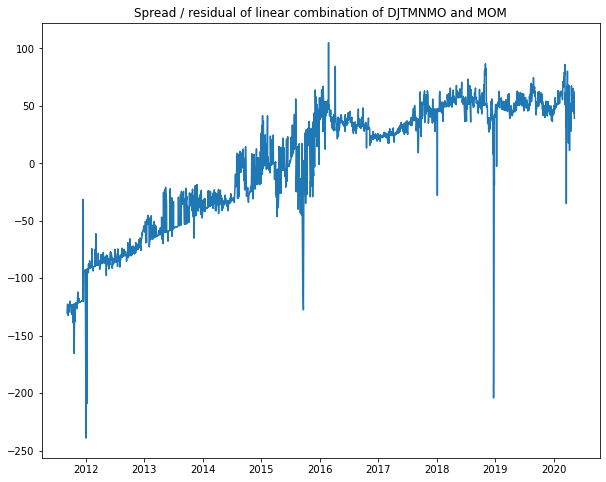

In [10]:
plt.figure(figsize=(10,8))
plt.title("Spread / residual of linear combination of DJTMNMO and MOM")
plt.plot(spread)

We clearly see that the time series has a strong trend. There is no need to run a proper stationarity test on the time series since the trend is extremely clear to the human eye. Because the spread time series is not stationary, we rule that the time series is not cointegrated. 

What about correlation? Let's see if we can make any conclusions about the correlation between the time series.

In [11]:
merged.corr().iloc[0]['DJT']

0.7357620468813384

We note that the time series have a relatively strong correlation when analyzed globally from all dates where both time series have data point entries. Let's look locally though. Let's analyze the time series locally and see if local correlation holds as well.

In [12]:
window_size = 100
corrs = []
for i in range(len(merged) - window_size):
    corr = merged.iloc[i: i + window_size].corr().iloc[0]['DJT']
    corrs.append(corr)

Text(0.5, 0, 'Date')

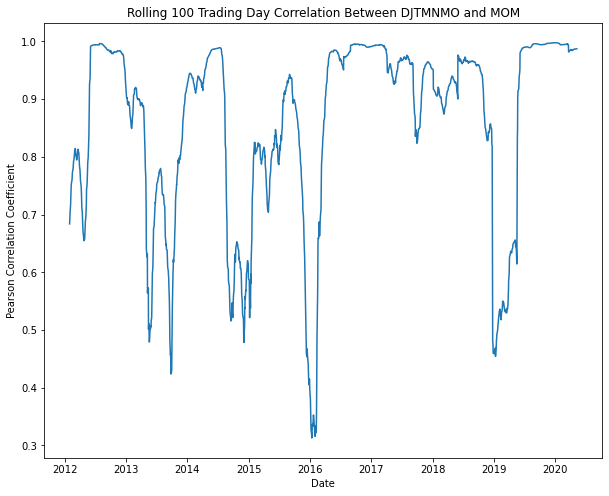

In [13]:
plt.figure(figsize=(10,8))
plt.plot(merged.iloc[window_size:].index, corrs)
plt.title(f"Rolling {window_size} Trading Day Correlation Between DJTMNMO and MOM")
plt.ylabel("Pearson Correlation Coefficient")
plt.xlabel("Date")

In [14]:
window_size = 200
corrs = []
for i in range(len(merged) - window_size):
    corr = merged.iloc[i: i + window_size].corr().iloc[0]['DJT']
    corrs.append(corr)

Text(0.5, 0, 'Date')

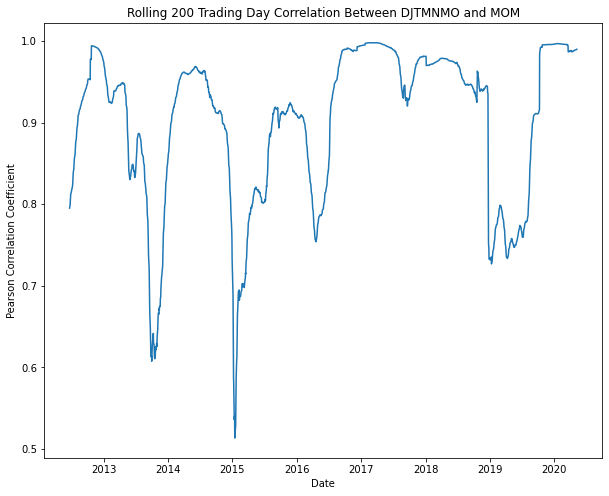

In [15]:
plt.figure(figsize=(10,8))
plt.plot(merged.iloc[window_size:].index, corrs)
plt.title(f"Rolling {window_size} Trading Day Correlation Between DJTMNMO and MOM")
plt.ylabel("Pearson Correlation Coefficient")
plt.xlabel("Date")

In [16]:
window_size = 50
corrs = []
for i in range(len(merged) - window_size):
    corr = merged.iloc[i: i + window_size].corr().iloc[0]['DJT']
    corrs.append(corr)

Text(0.5, 0, 'Date')

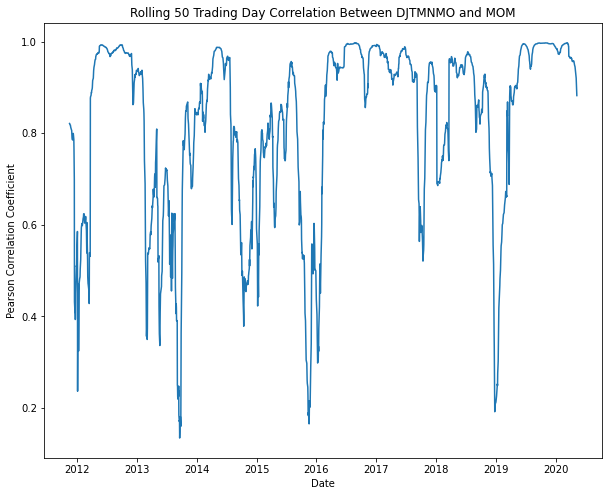

In [17]:
plt.figure(figsize=(10,8))
plt.plot(merged.iloc[window_size:].index, corrs)
plt.title(f"Rolling {window_size} Trading Day Correlation Between DJTMNMO and MOM")
plt.ylabel("Pearson Correlation Coefficient")
plt.xlabel("Date")

We looked at 50 trading days, 100 trading days and 200 trading day rolling windows and saw that there always is somewhat notable positive local correlation between the two time series. In the 200 trading day rolling window, the correlation is almost always notable and strong (greater than 0.5 and often above 0.8). In the 100 trading day rolling window, the correlation is also generally notable but there are time periods where the correlation becomes much weaker (coefficient close to 0.3). However, most of the time the 100 trading day rolling window has a correlation coefficient of 0.7 or more. The 50 trading day rolling window shows evidence that small local windows could be closer to decorrelation but for the most part, the story is the same: there is usually a notable positive correlation between the two time series.

We conclude that the time series DJTMNMO and MOM are globally and locally correlated. There are moments when local correlation is weaker but generally speaking there is almost always a notable correlation coefficient between small local windows in time for both time series.

## Question 3

We attempt to model DJTMNMO as a linear combination (plus intercept) of MTUM and SPY. We do an inner join on the three time series to match all dates with each other so we can analyze their relationship over the proper time periods.

In [18]:
DJT = DJTMNMO[['Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index']].rename(columns={'Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index':"DJT"})
tmp = DJT.merge(SPY[['Adj Close']].rename(columns={'Adj Close':'SPY'}), 
                   left_index=True,
                   right_index=True,
                   how='inner')
merged = tmp.merge(MTUM[['Adj Close']].rename(columns={'Adj Close':'MTUM'}), 
                   left_index=True,
                   right_index=True,
                   how='inner')
merged

,DJT,SPY,MTUM
2013-04-18,1053.16,130.269638,45.839806
2013-04-19,1063.54,131.402176,45.839806
2013-04-22,1065.90,131.985352,45.839806
2013-04-23,1070.00,133.345947,47.010105
2013-04-24,1064.72,133.430542,46.415951
...,...,...,...
2020-05-04,1347.57,275.469269,115.921417
2020-05-05,1363.20,278.014343,117.755028
2020-05-06,1372.54,276.129791,117.725456
2020-05-07,1373.43,279.461792,118.573265


In [19]:
reg = LinearRegression().fit(merged[['SPY','MTUM']], merged[['DJT']])
reg.coef_, reg.intercept_

(array([[-7.88291826, 17.11162022]]), array([1433.16053435]))

In [20]:
preds = reg.predict(merged[['SPY','MTUM']])
preds = pd.DataFrame(preds).set_index(merged[['DJT']].index)

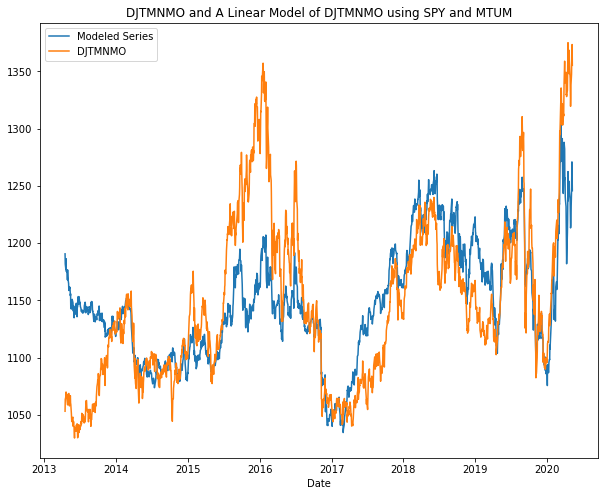

In [21]:
plt.figure(figsize=(10,8))
plt.plot(preds, label="Modeled Series")
plt.plot(merged[['DJT']], label='DJTMNMO')
plt.title("DJTMNMO and A Linear Model of DJTMNMO using SPY and MTUM")
plt.xlabel("Date")
plt.legend()

We see from the eye test that the two time series do in fact have a lot of simularities with eachother. There certainly are time periods where the predictions are relatively far away from the actual values but for most parts, the time series seem "close" to eachother. Let's get the correlation coefficient to confirm that our eye test holds

In [22]:
merged = pd.concat([preds, merged[['DJT']]], axis=1)
print(f"Global correlation of our predictions and the actual DJTMNMO is {merged.corr().iloc[0]['DJT']}")

Global correlation of our predictions and the actual DJTMNMO is 0.702517851414308


A correlation coefficient of 0.7 is certainly noteworthy.

Let's also do an eye test to see if the spread / residual is stationary (to see if the time series are cointegrated)

In [23]:
spread = merged['DJT'] - merged[0]
spread

2013-04-18   -137.488971
2013-04-19   -118.181267
2013-04-22   -111.224141
2013-04-23   -116.424398
2013-04-24   -110.870601
                 ...    
2020-05-04    102.307927
2020-05-05    106.624493
2020-05-06    101.614741
2020-05-07    114.263247
2020-05-08    109.443985
Length: 1778, dtype: float64

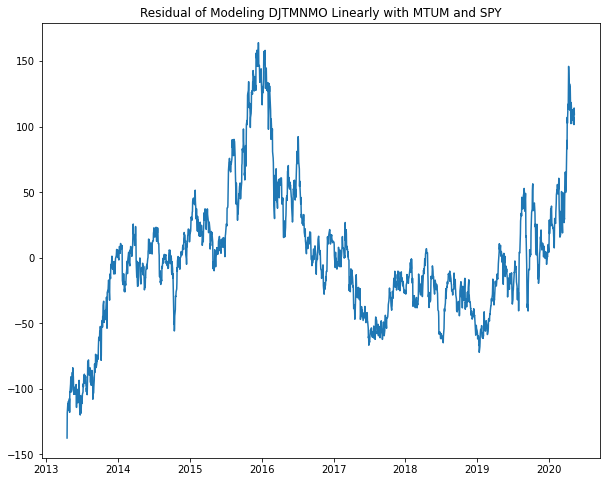

In [24]:
plt.figure(figsize=(10,8))
plt.title("Residual of Modeling DJTMNMO Linearly with MTUM and SPY")
plt.plot(spread)

Using the eye test, it seems that this time series is not stationary but much of the data hovers near 0 showing that our model has some explanatory power.

We have shown that a linear regression was able to reasonably model DJTMNMO using MTUM and SPY. The linear model that was fit was as follows: -7.9 * SPY + 17.1 * MTUM + 1433.2

This is interesting because the coefficient for SPY is negative while the coefficient for MTUM is positive (which is expected).